In [162]:
import pandas as pd
import matplotlib.pyplot as plt

In [163]:
df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")

In [164]:
solver_df = pd.merge(df[df.solver_version == "data-collection-10000"], input_df, how="left", on="input_file")
solver_df

,input_file,solver_version,score,duration,query_count,n,m,eps,dense
0,tools/in/0000.txt,data-collection-10000,3.651484,1.0357,21,15,2,0.01,0.168889
1,tools/in/0001.txt,data-collection-10000,9.805807,2.0784,51,13,6,0.04,0.159763
2,tools/in/0002.txt,data-collection-10000,3.922323,1.0320,21,13,2,0.07,0.402367
3,tools/in/0003.txt,data-collection-10000,3.244428,1.0298,21,19,2,0.08,0.315789
4,tools/in/0004.txt,data-collection-10000,61.871843,7.1188,351,16,8,0.14,0.367188
...,...,...,...,...,...,...,...,...,...
9995,tools/in/9995.txt,data-collection-10000,34.299717,5.0468,201,17,12,0.06,0.415225
9996,tools/in/9996.txt,data-collection-10000,56.777497,7.0366,351,19,6,0.14,0.404432
9997,tools/in/9997.txt,data-collection-10000,7.905694,2.0112,51,20,4,0.08,0.355000
9998,tools/in/9998.txt,data-collection-10000,40.824829,5.0395,201,12,5,0.16,0.222222


In [165]:
solver_df["query_count"] /= (solver_df["n"] ** 2) * 2

In [166]:
num_cols = ["score", "duration", "n", "m", "eps", "dense", "query_count"]
solver_df[num_cols].corr()

,score,duration,n,m,eps,dense,query_count
score,1.000000,0.611864,0.152620,0.423506,0.355524,-0.162416,0.731495
duration,0.611864,1.000000,0.495600,0.775759,0.479252,-0.168554,0.876595
n,0.152620,0.495600,1.000000,0.576731,-0.003959,0.004522,0.098047
m,0.423506,0.775759,0.576731,1.000000,-0.008044,-0.037341,0.548032
eps,0.355524,0.479252,-0.003959,-0.008044,1.000000,-0.013489,0.571394
dense,-0.162416,-0.168554,0.004522,-0.037341,-0.013489,1.000000,-0.212381
query_count,0.731495,0.876595,0.098047,0.548032,0.571394,-0.212381,1.000000


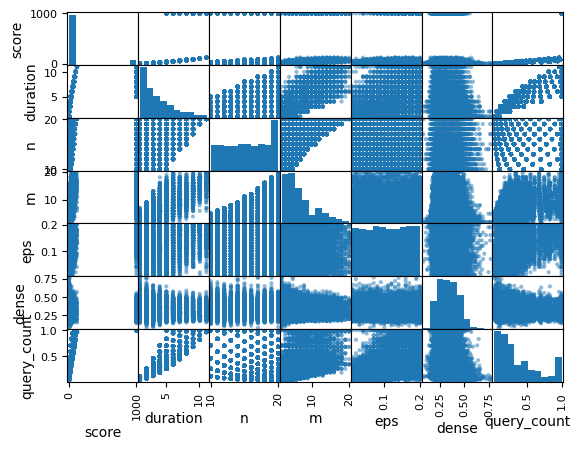

In [167]:
_ = pd.plotting.scatter_matrix(solver_df[num_cols])

<AxesSubplot:>

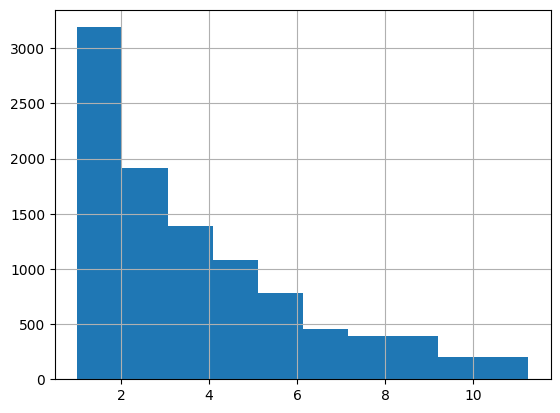

In [168]:
solver_df.duration.hist()

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")
solver_df = pd.merge(df[df.solver_version == "data-collection-10000"], input_df, how="left", on="input_file")

In [178]:
data_df = solver_df[num_cols]
# data_df["query_count"] /= (data_df["n"] ** 2) * 2
data_df.loc[:, ["target"]] = data_df["query_count"]

data_df = data_df.drop(["score", "duration", "query_count"], axis=1)

feature_cols = ["n", "m", "eps", "dense"]

alphas = [0.5, 0.8, 1.2, 1.5, 2.0]

# 特徴量
for col in feature_cols:
    for alpha in alphas:
        data_df.loc[:, [f"{col}.powf({alpha})"]] = data_df[col] ** alpha

for col1 in feature_cols:
    for alpha1 in alphas:
        for col2 in feature_cols:
            for alpha2 in alphas:
                c1 = f"{col1}.powf({alpha1})"
                c2 = f"{col2}.powf({alpha2})"
                data_df.loc[:, [f"{c1} * {c2}"]] = data_df[c1] * data_df[c2]
                data_df.loc[:, [f"{c1} / {c2}"]] = data_df[c1] / data_df[c2]

x = data_df.drop(["target"], axis=1)
y = data_df["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

model = Ridge(alpha=1e-3)
model.fit(train_x, train_y)

# print(model.coef_)
# print(model.intercept_)
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))
expr = " + ".join([f"{c:.5} * {t}" for c, t in zip(model.coef_.flatten(), x.columns)]) + f" + {model.intercept_:.5}"
print(expr)
with open("../log/expr.txt", "w") as f:
    f.write(expr + "\n")

0.892486869951351
0.8931560831525971
-0.33049 * n + -75.659 * m + 9.0044 * eps + -46.585 * dense + -4.0176 * n.powf(0.5) + -3.6445 * n.powf(0.8) + 6.4956 * n.powf(1.2) + 23.812 * n.powf(1.5) + 53.958 * n.powf(2.0) + -78.39 * m.powf(0.5) + -88.928 * m.powf(0.8) + -50.793 * m.powf(1.2) + -11.157 * m.powf(1.5) + 1.4889 * m.powf(2.0) + 0.74192 * eps.powf(0.5) + 3.9027 * eps.powf(0.8) + 15.366 * eps.powf(1.2) + 24.681 * eps.powf(1.5) + 33.535 * eps.powf(2.0) + -48.077 * dense.powf(0.5) + -52.25 * dense.powf(0.8) + -37.63 * dense.powf(1.2) + -24.345 * dense.powf(1.5) + -17.095 * dense.powf(2.0) + -0.33226 * n.powf(0.5) * n.powf(0.5) + 0.0 * n.powf(0.5) / n.powf(0.5) + 11.42 * n.powf(0.5) * n.powf(0.8) + 2.1662 * n.powf(0.5) / n.powf(0.8) + 38.113 * n.powf(0.5) * n.powf(1.2) + 3.5896 * n.powf(0.5) / n.powf(1.2) + 54.015 * n.powf(0.5) * n.powf(1.5) + 3.7156 * n.powf(0.5) / n.powf(1.5) + 19.159 * n.powf(0.5) * n.powf(2.0) + 2.9783 * n.powf(0.5) / n.powf(2.0) + -118.84 * n.powf(0.5) * m.powf(0.5

/Users/tatsuyaishii/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.90343e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


21 25.36062580409225
351 348.39354398178136
201 160.05254868164434
51 142.08004508944703
91 25.801371688603012
51 40.036874052067674
91 86.38975177360555
51 51.7591372339931
21 41.25388669420613
21 30.06600214216826


[-8.750602485418426, 851.5410515579002]

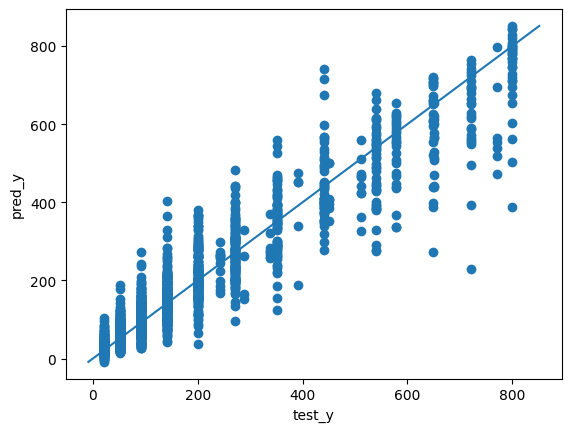

In [179]:
pred_y = model.predict(test_x)
for i in range(10):
    print(test_y.iloc[i], pred_y[i])

plt.scatter(test_y, pred_y)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min(), pred_y.max()])
[pred_y.min(), pred_y.max()]

In [172]:
import lightgbm as lgb
from sklearn.metrics import r2_score

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "random_state": 0,
    "verbose": -1
}

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
train_set = lgb.Dataset(train_x, train_y)
valid_set = lgb.Dataset(valid_x, valid_y, reference=train_set)

model = lgb.train(params=params, train_set=train_set, valid_sets=[valid_set], num_boost_round=1000)

pred_y = model.predict(test_x, num_iteration=model.best_iteration)
print(r2_score(test_y, pred_y))

0.8631856931969638


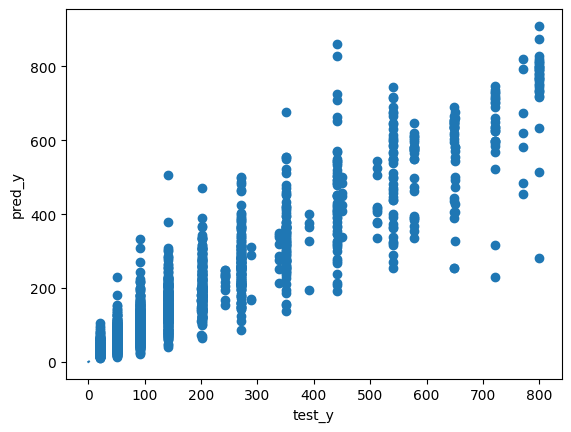

In [173]:
plt.scatter(test_y, pred_y)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([0, 1], [0, 1])